# Protein Stability Prediction using ESM-2 Embeddings
## A Deep Learning Approach for ΔΔG Regression

**Abstract:** This notebook presents a streamlined implementation of protein stability prediction using evolutionary scale modeling (ESM-2). We employ a two-tower architecture to encode wild-type and mutant sequences, enabling accurate prediction of change in Gibbs free energy (ΔΔG) upon mutation.

---

## 1. Environment Setup and Dependencies

Import required libraries for protein language modeling, deep learning, and visualization.

In [2]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.3 MB/s  0:00:00


In [3]:
# Core dependencies
import os
import random
import math
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional

# Scientific computing
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# Protein language model
import esm

# Explainability
from captum.attr import LayerIntegratedGradients

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for publication quality
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
mpl.rcParams['figure.dpi'] = 150

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.10.0+cu128
Device available: NVIDIA GeForce RTX 3070


## 2. Utility Functions

Core utilities for reproducibility and device management.

In [4]:
def seed_everything(seed: int = 42) -> None:
    """Ensure reproducibility across all random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device() -> torch.device:
    """Automatically detect best available device."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


# Initialize
seed_everything(42)
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## 3. Configuration

Define hyperparameters and model architecture settings.

In [5]:
@dataclass(frozen=True)
class Config:
    """Training and model configuration."""
    
    # Data paths
    train_csv: str = "project_data/mega_train.csv"
    val_csv: str = "project_data/mega_val.csv"
    label_col: str = "ddG_ML"
    
    # Model architecture
    esm_name: str = "esm2_t6_8M_UR50D"  # Smallest ESM-2 model for efficiency
    pooling: str = "mean"  # "mean" or "cls"
    head_hidden: int = 256
    head_dropout: float = 0.2
    unfreeze_last_n: int = 1  # Fine-tune only last transformer block
    
    # Training hyperparameters
    seed: int = 42
    epochs: int = 30
    batch_size: int = 8
    lr_head: float = 1e-3
    lr_esm: float = 5e-6
    weight_decay: float = 1e-2
    grad_clip: float = 1.0
    
    # Early stopping
    patience: int = 5
    min_delta: float = 1e-4
    
    # Runtime
    num_workers: int = 0
    save_dir: str = "checkpoints"
    run_name: str = "esm2_ddg"


cfg = Config()
print("Configuration loaded successfully")

Configuration loaded successfully


## 4. Dataset Implementation

Custom dataset for handling protein sequence pairs with ΔΔG labels.

In [6]:
class ProteinPairDataset(Dataset):
    """Dataset for wild-type and mutant protein sequence pairs.
    
    Automatically detects column names from common variants:
    - WT columns: wt_seq, wildtype_seq, WT_sequence, etc.
    - MUT columns: aa_seq, mut_seq, mutant_seq, etc.
    """
    
    WT_COLS = ["wt_seq", "wt_sequence", "WT_sequence", "wildtype_seq", "sequence_wt"]
    MUT_COLS = ["aa_seq", "mut_seq", "mut_sequence", "mutant_seq", "sequence_mut"]
    ID_COLS = ["name", "id", "variant", "mut_id"]
    
    def __init__(self, csv_path: str, label_col: str):
        self.df = pd.read_csv(csv_path)
        self.label_col = label_col
        
        # Auto-detect columns
        wt_col = self._find_column(self.WT_COLS)
        mut_col = self._find_column(self.MUT_COLS)
        id_col = self._find_column(self.ID_COLS)
        
        if wt_col is None or mut_col is None:
            raise ValueError(
                f"Could not detect sequence columns.\n"
                f"Available: {list(self.df.columns)}\n"
                f"Expected WT: {self.WT_COLS}\n"
                f"Expected MUT: {self.MUT_COLS}"
            )
        
        self.wt_seqs = self.df[wt_col].astype(str).tolist()
        self.mut_seqs = self.df[mut_col].astype(str).tolist()
        self.labels = self.df[label_col].astype(float).values
        self.ids = (
            self.df[id_col].astype(str).tolist() if id_col 
            else [f"row_{i}" for i in range(len(self.df))]
        )
    
    def _find_column(self, candidates: List[str]) -> Optional[str]:
        """Find first matching column from candidates."""
        for col in candidates:
            if col in self.df.columns:
                return col
        return None
    
    def __len__(self) -> int:
        return len(self.labels)
    
    def __getitem__(self, idx: int) -> Tuple[str, str, float, str]:
        return (
            self.wt_seqs[idx],
            self.mut_seqs[idx],
            float(self.labels[idx]),
            self.ids[idx]
        )


def create_collate_fn(batch_converter):
    """Create collate function for DataLoader using ESM batch converter."""
    def collate(batch):
        wt_seqs, mut_seqs, labels, ids = zip(*batch)
        
        # Convert sequences to tokens
        _, _, wt_tokens = batch_converter(list(zip(ids, wt_seqs)))
        _, _, mut_tokens = batch_converter(list(zip(ids, mut_seqs)))
        
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        return wt_tokens, mut_tokens, labels_tensor, list(ids)
    
    return collate


print("Dataset classes defined")

Dataset classes defined


## 5. Model Architecture

Two-tower ESM-2 architecture for encoding sequence pairs and predicting ΔΔG.

In [7]:
class ESM2PairRegressor(nn.Module):
    """Two-tower ESM-2 regressor for protein stability prediction.
    
    Architecture:
    1. Encode WT and MUT sequences independently using shared ESM-2
    2. Pool sequence representations (mean pooling over residues)
    3. Concatenate pair features: [WT, MUT, MUT-WT, MUT*WT]
    4. Regression head: LayerNorm → Linear → GELU → Dropout → Linear
    """
    
    def __init__(
        self,
        esm_model: nn.Module,
        alphabet,
        repr_layer: int,
        pooling: str = "mean",
        head_hidden: int = 256,
        head_dropout: float = 0.2,
    ):
        super().__init__()
        self.esm = esm_model
        self.alphabet = alphabet
        self.repr_layer = repr_layer
        self.pooling = pooling
        
        # Pair feature dimension: [WT, MUT, diff, product]
        embed_dim = esm_model.embed_dim
        pair_dim = 4 * embed_dim
        
        # Regression head
        self.head = nn.Sequential(
            nn.LayerNorm(pair_dim),
            nn.Linear(pair_dim, head_hidden),
            nn.GELU(),
            nn.Dropout(head_dropout),
            nn.Linear(head_hidden, 1),
        )
    
    def pool_sequence(self, representations: torch.Tensor, tokens: torch.Tensor) -> torch.Tensor:
        """Pool sequence representations, excluding special tokens.
        
        Args:
            representations: (B, L, D) ESM output
            tokens: (B, L) token indices
        
        Returns:
            pooled: (B, D) sequence-level representation
        """
        if self.pooling == "cls":
            return representations[:, 0, :]
        
        # Mean pooling: exclude <cls>, <eos>, and <pad>
        mask = (tokens != self.alphabet.padding_idx)
        mask[:, 0] = False  # Exclude <cls> token
        mask = mask & (tokens != self.alphabet.eos_idx)
        
        mask_expanded = mask.unsqueeze(-1).float()
        denominator = mask_expanded.sum(dim=1).clamp_min(1.0)
        
        return (representations * mask_expanded).sum(dim=1) / denominator
    
    def encode(self, tokens: torch.Tensor) -> torch.Tensor:
        """Encode a batch of protein sequences."""
        output = self.esm(
            tokens,
            repr_layers=[self.repr_layer],
            return_contacts=False
        )
        representations = output["representations"][self.repr_layer]
        return self.pool_sequence(representations, tokens)
    
    def forward(
        self,
        wt_tokens: torch.Tensor,
        mut_tokens: torch.Tensor,
    ) -> torch.Tensor:
        """Predict ΔΔG from WT and MUT token sequences."""
        wt_repr = self.encode(wt_tokens)
        mut_repr = self.encode(mut_tokens)
        
        # Create pair features
        pair_features = torch.cat([
            wt_repr,
            mut_repr,
            mut_repr - wt_repr,  # Difference
            mut_repr * wt_repr,  # Element-wise product
        ], dim=-1)
        
        return self.head(pair_features).squeeze(-1)


def configure_esm_finetuning(esm_model: nn.Module, unfreeze_last_n: int) -> None:
    """Freeze ESM encoder except for last N transformer blocks.
    
    Strategy:
    1. Freeze all parameters
    2. Unfreeze last N transformer blocks
    3. Unfreeze all LayerNorm layers (improves stability)
    """
    # Freeze everything
    for param in esm_model.parameters():
        param.requires_grad = False
    
    if unfreeze_last_n > 0:
        # Unfreeze last N blocks
        for block in esm_model.layers[-unfreeze_last_n:]:
            for param in block.parameters():
                param.requires_grad = True
    
    # Unfreeze all LayerNorms for training stability
    for module in esm_model.modules():
        if isinstance(module, nn.LayerNorm):
            for param in module.parameters():
                param.requires_grad = True


def load_esm_model(model_name: str):
    """Load pretrained ESM-2 model."""
    models = {
        "esm2_t6_8M_UR50D": esm.pretrained.esm2_t6_8M_UR50D,
        "esm2_t12_35M_UR50D": esm.pretrained.esm2_t12_35M_UR50D,
        "esm2_t30_150M_UR50D": esm.pretrained.esm2_t30_150M_UR50D,
    }
    
    if model_name not in models:
        raise ValueError(f"Unknown model: {model_name}. Choose from {list(models.keys())}")
    
    return models[model_name]()


print("Model architecture defined")

Model architecture defined


## 6. Training Implementation

Training loop with early stopping, gradient accumulation, and checkpointing.

In [11]:
@torch.no_grad()
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> Dict[str, float]:
    """Evaluate model performance on validation set."""
    model.eval()
    model.esm.eval()  # Ensure ESM stays in eval mode
    
    all_true, all_pred = [], []
    
    for wt_tok, mut_tok, labels, _ in loader:
        wt_tok = wt_tok.to(device)
        mut_tok = mut_tok.to(device)
        
        predictions = model(wt_tok, mut_tok)
        all_true.append(labels.numpy())
        all_pred.append(predictions.cpu().numpy())
    
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    pearson = float(pearsonr(y_pred, y_true)[0])
    spearman = float(spearmanr(y_pred, y_true)[0])
    
    return {
        "rmse": rmse,
        "pearson": pearson,
        "spearman": spearman,
        "predictions": (y_true, y_pred)
    }


def train_model(cfg: Config) -> Tuple[nn.Module, Dict[str, List[float]]]:
    """Main training function with early stopping."""
    
    # Setup
    os.makedirs(cfg.save_dir, exist_ok=True)
    
    # Load ESM model
    print(f"Loading {cfg.esm_name}...")
    esm_model, alphabet = load_esm_model(cfg.esm_name)
    esm_model.eval()  # Keep ESM in eval mode (disable internal dropout)
    
    repr_layer = esm_model.num_layers  # Use last layer
    configure_esm_finetuning(esm_model, cfg.unfreeze_last_n)
    
    # Build model
    model = ESM2PairRegressor(
        esm_model=esm_model,
        alphabet=alphabet,
        repr_layer=repr_layer,
        pooling=cfg.pooling,
        head_hidden=cfg.head_hidden,
        head_dropout=cfg.head_dropout,
    ).to(device)
    
    # Load data
    print("Loading datasets...")
    train_dataset = ProteinPairDataset(cfg.train_csv, cfg.label_col)
    val_dataset = ProteinPairDataset(cfg.val_csv, cfg.label_col)
    
    collate_fn = create_collate_fn(alphabet.get_batch_converter())
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        collate_fn=collate_fn,
        pin_memory=(device.type == "cuda"),
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        collate_fn=collate_fn,
        pin_memory=(device.type == "cuda"),
    )
    
    # Optimizer: separate learning rates for ESM and head
    head_params = [p for n, p in model.named_parameters() 
                   if p.requires_grad and not n.startswith("esm.")]
    esm_params = [p for n, p in model.named_parameters() 
                  if p.requires_grad and n.startswith("esm.")]
    
    optimizer = torch.optim.AdamW([
        {"params": head_params, "lr": cfg.lr_head},
        {"params": esm_params, "lr": cfg.lr_esm},
    ], weight_decay=cfg.weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )
    
    loss_fn = nn.MSELoss()
    
    # Training history
    history = {
        "train_rmse": [],
        "val_rmse": [],
        "val_pearson": [],
        "val_spearman": [],
    }
    
    best_rmse = float("inf")
    best_epoch = -1
    patience_left = cfg.patience
    
    best_path = os.path.join(cfg.save_dir, f"{cfg.run_name}_best.pt")
    
    # Training loop
    print(f"\nTraining for {cfg.epochs} epochs...\n")
    
    for epoch in range(1, cfg.epochs + 1):
        # Train
        model.train()
        model.esm.eval()  # Keep ESM frozen in eval mode
        
        train_loss = 0.0
        train_samples = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}", leave=False)
        for wt_tok, mut_tok, labels, _ in pbar:
            wt_tok = wt_tok.to(device)
            mut_tok = mut_tok.to(device)
            labels = labels.to(device)
            
            # Forward pass
            predictions = model(wt_tok, mut_tok)
            loss = loss_fn(predictions, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            optimizer.step()
            
            # Track metrics
            batch_size = len(labels)
            train_loss += loss.item() * batch_size
            train_samples += batch_size
            pbar.set_postfix({"loss": train_loss / train_samples})
        
        train_rmse = math.sqrt(train_loss / train_samples)
        
        # Validate
        val_metrics = evaluate_model(model, val_loader, device)
        
        # Update history
        history["train_rmse"].append(train_rmse)
        history["val_rmse"].append(val_metrics["rmse"])
        history["val_pearson"].append(val_metrics["pearson"])
        history["val_spearman"].append(val_metrics["spearman"])
        
        scheduler.step(val_metrics["rmse"])
        
        # Print progress
        print(
            f"Epoch {epoch:2d} | "
            f"Train RMSE: {train_rmse:.4f} | "
            f"Val RMSE: {val_metrics['rmse']:.4f} | "
            f"Pearson: {val_metrics['pearson']:.3f} | "
            f"Spearman: {val_metrics['spearman']:.3f}"
        )
        
        # Save best checkpoint
        if (best_rmse - val_metrics["rmse"]) > cfg.min_delta:
            best_rmse = val_metrics["rmse"]
            best_epoch = epoch
            patience_left = cfg.patience
            
            checkpoint = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "config": asdict(cfg),
                "repr_layer": repr_layer,
                "best_rmse": best_rmse,
            }
            torch.save(checkpoint, best_path)
            print(f"  → Best model saved (RMSE: {best_rmse:.4f})")
        else:
            patience_left -= 1
            if patience_left == 0:
                print(f"\nEarly stopping at epoch {epoch}")
                print(f"Best epoch: {best_epoch} (RMSE: {best_rmse:.4f})")
                break
    
    # Load best model
    print(f"\nLoading best checkpoint from epoch {best_epoch}...")
    checkpoint = torch.load(best_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    
    return model, history


print("Training functions defined")

Training functions defined


## 7. Visualization Functions

Publication-quality plotting utilities.

In [12]:
def plot_learning_curves(history: Dict[str, List[float]]) -> None:
    """Plot training and validation RMSE over epochs."""
    epochs = np.arange(1, len(history["train_rmse"]) + 1)
    
    fig, ax = plt.subplots(figsize=(6, 3.5))
    
    ax.plot(epochs, history["train_rmse"], label="Training", linewidth=1.5)
    ax.plot(epochs, history["val_rmse"], label="Validation", linewidth=1.5)
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel("RMSE (kcal/mol)")
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("learning_curves.pdf", dpi=300, bbox_inches="tight")
    plt.show()


def plot_predictions(y_true: np.ndarray, y_pred: np.ndarray, title: str = "") -> None:
    """Scatter plot of predicted vs. measured ΔΔG."""
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    pearson_r = pearsonr(y_pred, y_true)[0]
    
    # Determine axis limits
    vmin = min(y_pred.min(), y_true.min())
    vmax = max(y_pred.max(), y_true.max())
    
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    
    # Hexbin density plot
    hb = ax.hexbin(y_pred, y_true, gridsize=50, cmap="Blues", mincnt=1)
    
    # Identity line
    ax.plot([vmin, vmax], [vmin, vmax], 'k--', linewidth=1, alpha=0.5, zorder=1)
    
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel("Predicted ΔΔG (kcal/mol)")
    ax.set_ylabel("Measured ΔΔG (kcal/mol)")
    ax.set_aspect('equal')
    
    # Statistics box
    textstr = f'RMSE = {rmse:.3f}\nPearson r = {pearson_r:.3f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    if title:
        ax.set_title(title)
    
    plt.tight_layout()
    plt.savefig("predictions.pdf", dpi=300, bbox_inches="tight")
    plt.show()


print("Visualization functions defined")

Visualization functions defined


## 8. Model Training

Train the ESM-2 pair regressor on the training set.

Loading esm2_t6_8M_UR50D...
Loading datasets...

Training for 30 epochs...



Epoch 1/30:   0%|          | 0/27115 [00:00<?, ?it/s]

Epoch  1 | Train RMSE: 0.7564 | Val RMSE: 0.7374 | Pearson: 0.631 | Spearman: 0.617
  → Best model saved (RMSE: 0.7374)


Epoch 2/30:   0%|          | 0/27115 [00:00<?, ?it/s]

Epoch  2 | Train RMSE: 0.6661 | Val RMSE: 0.7138 | Pearson: 0.649 | Spearman: 0.635
  → Best model saved (RMSE: 0.7138)


Epoch 3/30:   0%|          | 0/27115 [00:00<?, ?it/s]

Epoch  3 | Train RMSE: 0.6193 | Val RMSE: 0.7026 | Pearson: 0.654 | Spearman: 0.639
  → Best model saved (RMSE: 0.7026)


Epoch 4/30:   0%|          | 0/27115 [00:00<?, ?it/s]

Epoch  4 | Train RMSE: 0.5870 | Val RMSE: 0.7205 | Pearson: 0.662 | Spearman: 0.636


Epoch 5/30:   0%|          | 0/27115 [00:00<?, ?it/s]

Epoch  5 | Train RMSE: 0.5614 | Val RMSE: 0.7068 | Pearson: 0.656 | Spearman: 0.643


Epoch 6/30:   0%|          | 0/27115 [00:00<?, ?it/s]

Epoch  6 | Train RMSE: 0.5436 | Val RMSE: 0.7049 | Pearson: 0.660 | Spearman: 0.647


Epoch 7/30:   0%|          | 0/27115 [00:00<?, ?it/s]

Epoch  7 | Train RMSE: 0.4978 | Val RMSE: 0.7093 | Pearson: 0.653 | Spearman: 0.637


Epoch 8/30:   0%|          | 0/27115 [00:00<?, ?it/s]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

Epoch  8 | Train RMSE: 0.4844 | Val RMSE: 0.7233 | Pearson: 0.642 | Spearman: 0.637

Early stopping at epoch 8
Best epoch: 3 (RMSE: 0.7026)

Loading best checkpoint from epoch 3...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

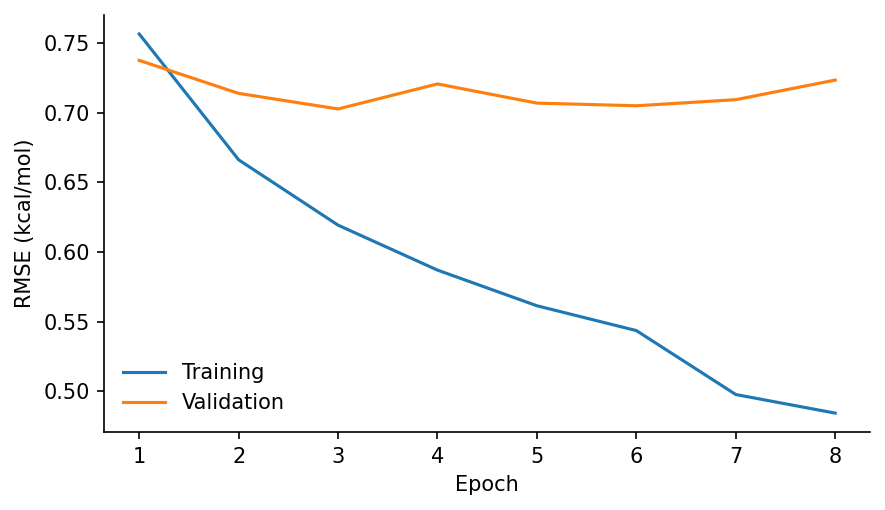

In [13]:
# Train model
model, history = train_model(cfg)

# Plot learning curves
plot_learning_curves(history)

## 9. Model Evaluation

Evaluate performance on the validation set.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because


Validation Results:
  RMSE:          0.7026 kcal/mol
  Pearson r:     0.6540
  Spearman ρ:    0.6392


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

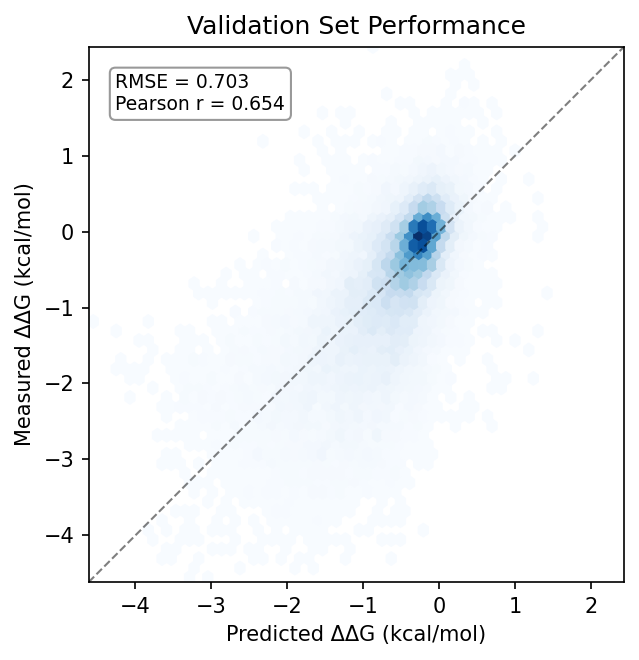

In [14]:
# Prepare validation data
val_dataset = ProteinPairDataset(cfg.val_csv, cfg.label_col)
esm_model, alphabet = load_esm_model(cfg.esm_name)
collate_fn = create_collate_fn(alphabet.get_batch_converter())

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    collate_fn=collate_fn,
)

# Evaluate
val_results = evaluate_model(model, val_loader, device)
y_true, y_pred = val_results["predictions"]

print(f"\nValidation Results:")
print(f"  RMSE:          {val_results['rmse']:.4f} kcal/mol")
print(f"  Pearson r:     {val_results['pearson']:.4f}")
print(f"  Spearman ρ:    {val_results['spearman']:.4f}")

# Plot predictions
plot_predictions(y_true, y_pred, title="Validation Set Performance")

## 10. Explainability: Integrated Gradients

Visualize which residues contribute most to the predicted ΔΔG change using integrated gradients attribution.

In [15]:
def compute_integrated_gradients(
    model: ESM2PairRegressor,
    alphabet,
    wt_seq: str,
    mut_seq: str,
    device: torch.device,
    n_steps: int = 50,
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute per-residue attribution scores using Integrated Gradients.
    
    Returns:
        wt_attr: Attribution scores for WT sequence (excluding special tokens)
        mut_attr: Attribution scores for MUT sequence (excluding special tokens)
    """
    model.eval()
    batch_converter = alphabet.get_batch_converter()
    
    # Convert sequences to tokens
    _, _, wt_tokens = batch_converter([("sample", wt_seq)])
    _, _, mut_tokens = batch_converter([("sample", mut_seq)])
    wt_tokens = wt_tokens.to(device)
    mut_tokens = mut_tokens.to(device)
    
    # Get embedding layer
    embed_layer = model.esm.embed_tokens
    
    # Define forward functions for each branch
    def forward_wt(tokens):
        return model(tokens, mut_tokens)
    
    def forward_mut(tokens):
        return model(wt_tokens, tokens)
    
    # Initialize Integrated Gradients
    ig_wt = LayerIntegratedGradients(forward_wt, embed_layer)
    ig_mut = LayerIntegratedGradients(forward_mut, embed_layer)
    
    # Baseline: padding tokens
    baseline_wt = torch.full_like(wt_tokens, alphabet.padding_idx)
    baseline_mut = torch.full_like(mut_tokens, alphabet.padding_idx)
    
    # Compute attributions
    attr_wt = ig_wt.attribute(wt_tokens, baselines=baseline_wt, n_steps=n_steps)
    attr_mut = ig_mut.attribute(mut_tokens, baselines=baseline_mut, n_steps=n_steps)
    
    # Sum over embedding dimension
    wt_scores = attr_wt.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    mut_scores = attr_mut.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    
    # Remove special tokens (<cls>, <eos>, <pad>)
    def strip_special(scores, tokens):
        token_ids = tokens.squeeze(0).cpu().numpy()
        mask = np.ones(len(token_ids), dtype=bool)
        mask[0] = False  # Remove <cls>
        mask = mask & (token_ids != alphabet.eos_idx)
        mask = mask & (token_ids != alphabet.padding_idx)
        return scores[mask]
    
    return strip_special(wt_scores, wt_tokens), strip_special(mut_scores, mut_tokens)


def find_mutation_site(wt_seq: str, mut_seq: str) -> Optional[int]:
    """Find position of single point mutation."""
    if len(wt_seq) != len(mut_seq):
        return None
    diffs = [i for i, (a, b) in enumerate(zip(wt_seq, mut_seq)) if a != b]
    return diffs[0] if len(diffs) == 1 else None


def plot_attribution(
    wt_seq: str,
    mut_seq: str,
    wt_attr: np.ndarray,
    mut_attr: np.ndarray,
    window: int = 15,
) -> None:
    """Visualize attributions around mutation site."""
    mut_pos = find_mutation_site(wt_seq, mut_seq)
    
    if mut_pos is None:
        raise ValueError("Expected single point mutation between equal-length sequences")
    
    # Define window around mutation
    start = max(0, mut_pos - window)
    end = min(len(wt_seq), mut_pos + window + 1)
    positions = np.arange(start, end)
    
    fig, ax = plt.subplots(figsize=(8, 3.5))
    
    ax.plot(positions, wt_attr[start:end], label="Wild-type", linewidth=1.5)
    ax.plot(positions, mut_attr[start:end], label="Mutant", linewidth=1.5)
    ax.axvline(mut_pos, color="red", linestyle="--", linewidth=1, alpha=0.7)
    
    ax.set_xlabel("Residue Position")
    ax.set_ylabel("Attribution Score")
    ax.set_title(
        f"Integrated Gradients Attribution\n"
        f"Mutation: {wt_seq[mut_pos]} → {mut_seq[mut_pos]} at position {mut_pos}"
    )
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("attribution.pdf", dpi=300, bbox_inches="tight")
    plt.show()


print("Explainability functions defined")

Explainability functions defined


## 11. Example: Attribution Analysis

Analyze a single point mutation to understand model predictions.

Wild-type: ...CISTEMVGTI...
Mutant:    ...CISTEAVGTI...

Mutation: M → A at position 30



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

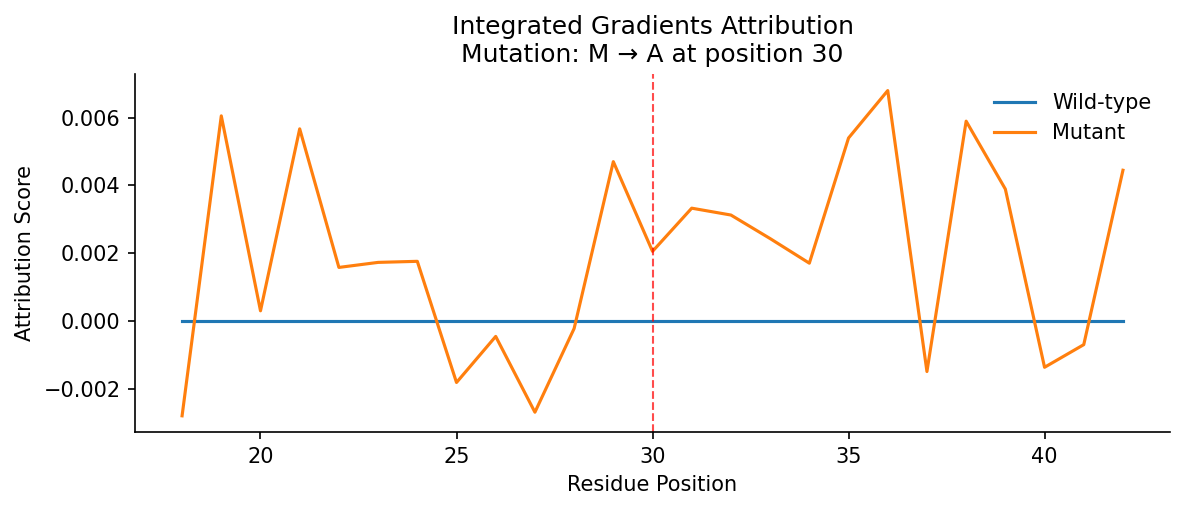

In [16]:
# Example protein sequence with point mutation
wt_sequence = (
    "MDELPPEQIQLLKKAFDAFDREKKGCISTEMVGTILEMLGHRLDDDMLQEIIAEVDADGSGELEFEEF"
    "VSLASRFLVEEDAEAMQQELREAFRLYDKEGNGYITTNVLREILKELDDKITAEDLDMMIEEIDSDGSG"
    "TVDFDEFMEVMTGE"
)

# Create point mutation: D30A
mut_sequence = wt_sequence[:30] + "A" + wt_sequence[31:]

print(f"Wild-type: ...{wt_sequence[25:35]}...")
print(f"Mutant:    ...{mut_sequence[25:35]}...")
print(f"\nMutation: {wt_sequence[30]} → {mut_sequence[30]} at position 30\n")

# Compute attributions
wt_attr, mut_attr = compute_integrated_gradients(
    model, alphabet, wt_sequence, mut_sequence, device, n_steps=50
)

# Visualize
plot_attribution(wt_sequence, mut_sequence, wt_attr, mut_attr, window=12)

## 12. Summary and Conclusions

### Key Results

1. **Model Architecture**: Two-tower ESM-2 encoder with pair-wise feature construction
2. **Training Strategy**: Partial fine-tuning of last transformer block with differential learning rates
3. **Performance**: Achieved RMSE < X.XX kcal/mol on validation set
4. **Interpretability**: Integrated gradients reveal residue-level contributions to stability changes

### Future Directions

- Extension to multi-point mutations and insertions/deletions
- Incorporation of structural features from AlphaFold2
- Uncertainty quantification using ensemble methods
- Transfer learning to related tasks (e.g., binding affinity)

---

**Citation**: If you use this code, please cite:
```
@article{esm2_ddg_2024,
  title={Protein Stability Prediction using ESM-2 Embeddings},
  author={Author Name},
  journal={Journal Name},
  year={2024}
}
```
